In [ ]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Path to your zip archive (update this)
zip_path = '/content/diabetes-data.zip'

# Codes for insulin and glucose measurements as strings (to match data)
insulin_codes = {'33', '34', '35'}
glucose_codes = {'48', '57', '58', '59', '60', '61', '62', '63', '64'}

def convert_time(row):
    try:
        # Try parsing date and time string normally
        return pd.to_datetime(row['date'] + ' ' + row['time'])
    except:
        # Handle special logical time labels (e.g., breakfast, lunch) by mapping them to fixed times
        logical_times = {'breakfast': '08:00', 'lunch': '12:00', 'dinner': '18:00', 'bedtime': '22:00'}
        time_str = row['time'].lower()
        if time_str in logical_times:
            # Convert date + mapped logical time to datetime
            return pd.to_datetime(row['date'] + ' ' + logical_times[time_str])
        else:
            # If time format unknown, return NaT (Not a Time)
            return pd.NaT

# Open zip file and extract all patient data files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Filter only files with patient data path pattern
    patient_files = [f for f in zip_ref.namelist() if 'Diabetes-Data/data-' in f]
    all_dfs = []
    for file in patient_files:
        # Read each patient file as a dataframe with specified columns
        with zip_ref.open(file) as f:
            df = pd.read_csv(f, sep='\t', header=None, names=['date', 'time', 'code', 'value'], dtype=str)
            # Add patient_id column using filename to track patient origin
            df['patient_id'] = file
            all_dfs.append(df)

# Combine all patient dataframes into one large dataframe
raw_df = pd.concat(all_dfs, ignore_index=True)

# Keep only rows with insulin or glucose measurement codes
filtered_df = raw_df[raw_df['code'].isin(insulin_codes.union(glucose_codes))].copy()

# Apply function to convert date and time columns into single datetime column
filtered_df['datetime'] = filtered_df.apply(convert_time, axis=1)

# Remove rows where datetime conversion failed (NaT)
filtered_df.dropna(subset=['datetime'], inplace=True)

# Convert the 'value' column to numeric; convert invalid parsing to NaN
filtered_df['value'] = pd.to_numeric(filtered_df['value'], errors='coerce')

# Drop rows where 'value' could not be converted to numeric
filtered_df.dropna(subset=['value'], inplace=True)

# Create a new column to label feature as 'insulin' or 'glucose' based on code
filtered_df['feature_type'] = filtered_df['code'].apply(
    lambda c: 'insulin' if c in insulin_codes else 'glucose')

# Reshape data to wide format: each row is patient_id + datetime with insulin and glucose columns
pivot_df = filtered_df.pivot_table(
    index=['patient_id', 'datetime'], columns='feature_type', values='value', aggfunc='sum').reset_index()

# Fill missing insulin values with 0, assuming no dose given
pivot_df['insulin'] = pivot_df['insulin'].fillna(0)

# Fill missing glucose values by carrying forward last valid measurement
pivot_df['glucose'] = pivot_df['glucose'].fillna(method='ffill')

# If glucose still missing (e.g., at start), fill with median glucose value of dataset
pivot_df['glucose'].fillna(pivot_df['glucose'].median(), inplace=True)

# Explicitly convert insulin and glucose columns to float type
pivot_df['insulin'] = pivot_df['insulin'].astype(float)
pivot_df['glucose'] = pivot_df['glucose'].astype(float)

# Normalize insulin and glucose features using StandardScaler (mean=0, std=1)
scaler = StandardScaler()
pivot_df[['insulin_norm', 'glucose_norm']] = scaler.fit_transform(pivot_df[['insulin', 'glucose']])

# Sort data by patient_id and datetime for ordered analysis
pivot_df.sort_values(['patient_id', 'datetime'], inplace=True)
pivot_df.reset_index(drop=True, inplace=True)

# Output preview of the final prepared dataframe
print(pivot_df.head())

feature_type                           patient_id            datetime  \
0             diabetes-data/Diabetes-Data/data-01 1991-04-21 09:09:00   
1             diabetes-data/Diabetes-Data/data-01 1991-04-21 17:08:00   
2             diabetes-data/Diabetes-Data/data-01 1991-04-21 22:51:00   
3             diabetes-data/Diabetes-Data/data-01 1991-04-22 07:35:00   
4             diabetes-data/Diabetes-Data/data-01 1991-04-22 13:40:00   

feature_type  glucose  insulin  insulin_norm  glucose_norm  
0               100.0     22.0      1.151959     -0.763804  
1               119.0      7.0     -0.073814     -0.533646  
2               123.0      0.0     -0.645842     -0.485191  
3               216.0     23.0      1.233678      0.641375  
4               216.0      2.0     -0.482406      0.641375  


/tmp/ipython-input-596867487.py:71: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot_df['glucose'] = pivot_df['glucose'].fillna(method='ffill')
/tmp/ipython-input-596867487.py:74: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pivot_df['glucose'].fillna(pivot_df['glucose'].median(), inplace=True)


In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class DiabetesEnv(gym.Env):
    metadata = {'render_modes': ['human']}  # Supported render modes

    def __init__(self, data):
        super().__init__()
        self.data = data
        # Extract unique patient IDs from the data
        self.patients = data['patient_id'].unique()

        # Features used: normalized insulin (related to action), normalized glucose (state)
        self.features = ['insulin_norm', 'glucose_norm']

        # Define discrete action space: 3 possible insulin dose adjustments
        # 0 = no adjustment, 1 = moderate dose, 2 = high dose
        self.action_space = spaces.Discrete(3)

        # Observation space includes normalized insulin and glucose as continuous values
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(2,), dtype=np.float32)

        # Initialize indices and patient data placeholders
        self.current_patient_idx = None
        self.current_time_idx = None
        self.current_patient_data = None
        self.render_mode = None  # Render mode (e.g., 'human')

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Randomly select a patient index to start
        self.current_patient_idx = np.random.randint(len(self.patients))
        patient_id = self.patients[self.current_patient_idx]

        # Extract data for the selected patient and reset index
        self.current_patient_data = self.data[self.data['patient_id'] == patient_id].reset_index(drop=True)
        self.current_time_idx = 0  # Start at the first time step

        # Return initial state and empty info dict as per gym API
        return self._get_state(), {}

    def _get_state(self):
        # Get feature values for the current timestep as float32 numpy array
        row = self.current_patient_data.iloc[self.current_time_idx]
        return row[self.features].values.astype(np.float32)

    def step(self, action):
        # Get current state
        current_state = self._get_state()
        done = False

        # Check if this is the last time step for the current patient
        if self.current_time_idx + 1 >= len(self.current_patient_data):
            done = True
            # If done, next state is zero vector (episode end)
            next_state = np.zeros_like(current_state)
            reward = 0.0
            reward_health = 0.0
            side_effect = 0.0
            cost = 0.0
        else:
            # Get next state features from next timestep
            next_state = self.current_patient_data.iloc[self.current_time_idx + 1][self.features].values.astype(np.float32)

            # Calculate health reward: positive if glucose decreases (improvement)
            reward_health = current_state[1] - next_state[1]

            # Calculate penalties proportional to action intensity
            side_effect = 0.05 * action  # Side effect cost
            cost = 1.0 * action  # Treatment cost

            # Net reward is health improvement minus side effects and cost
            reward = reward_health - side_effect - cost

            # Advance time step
            self.current_time_idx += 1

        # Info dictionary with reward components for diagnostics
        info = {
            'reward_health': reward_health,
            'reward_side_effect': -side_effect,
            'reward_cost': -cost
        }

        # If render mode set to human, display current state info
        if self.render_mode == 'human':
            self.render()

        # Return next state, reward, done flag, truncated flag (False), and info dict
        return next_state, float(reward), done, False, info

    def render(self):
        # Print current patient and time step details
        print(f"Patient: {self.patients[self.current_patient_idx]}, Time Step: {self.current_time_idx}")
        # Print current state feature values
        print(f"Current State (Insulin_norm, Glucose_norm): {self._get_state()}")

In [ ]:
# Install stable-baselines3 with extra dependencies (run once)
!pip install stable-baselines3[extra]

from stable_baselines3 import PPO  # Import Proximal Policy Optimization algorithm
from stable_baselines3.common.env_checker import check_env  # Tool to validate custom gym environments

# Assume 'pivot_df' DataFrame and DiabetesEnv class are already defined and loaded from previous steps

# Instantiate the custom diabetes environment using the prepared dataset
env = DiabetesEnv(pivot_df)

# Check that the environment follows Gym API and is compatible with stable-baselines3
check_env(env, warn=True)

# Create a PPO model with MLP (multi-layer perceptron) policy for function approximation
model = PPO(
    "MlpPolicy",   # Use MLP neural network policy
    env,           # Environment to train on
    verbose=1,     # Enable logging output for progress monitoring
    learning_rate=3e-4,  # Learning rate for optimizer
    batch_size=64,       # Mini-batch size for training updates
    n_steps=2048,        # Number of steps to run for each environment update
    gamma=0.99,          # Discount factor for future rewards
    seed=42,             # Random seed for reproducibility
)

# Train the PPO model for 30,000 time steps (can adjust this value based on convergence)
model.learn(total_timesteps=30000)

# Save the trained model to disk for future use or evaluation
model.save("ppo_diabetes_model")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 211      |
|    ep_rew_mean     | -224     |
| time/              |          |
|    fps             | 531      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 248         |
|    ep_rew_mean          | -249        |
| time/                   |             |
|    fps                  | 470         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008255605 |
|    clip_fraction        | 0.0447      |
|    clip_range           | 0.2         |
|    entropy_loss   

In [ ]:
import numpy as np

# Load the previously saved PPO model and pass the environment for compatibility
model = PPO.load("ppo_diabetes_model", env=env)

# Reset the environment to start a new evaluation episode
obs, _ = env.reset()
done = False

# Initialize lists to record rewards, components, actions, and states for analysis
rewards = []
reward_health = []
reward_side_effect = []
reward_cost = []
actions_taken = []
states = []

# Run the episode until the environment signals done
while not done:
    # Predict the next action using the trained model based on current observation
    action, _states = model.predict(obs)

    # Take the action in the environment, receive next state, reward, done flag, etc.
    obs, reward, done, truncated, info = env.step(action)

    # Store overall reward
    rewards.append(reward)

    # Store individual reward components from info dictionary
    reward_health.append(info['reward_health'])
    # Side effect and cost are stored negative in info, so negate again to get positive penalty values
    reward_side_effect.append(-info['reward_side_effect'])
    reward_cost.append(-info['reward_cost'])

    # Log the action taken and resulting state for further inspection
    actions_taken.append(action)
    states.append(obs)

    # Optional: render the environment's current state for visual inspection
    # env.render()

# Print summary statistics after episode ends
print(f"Total Episode Reward: {np.sum(rewards):.2f}")
print(f"Average Reward per Step: {np.mean(rewards):.2f}")
print(f"Total Health Improvement: {np.sum(reward_health):.2f}")
print(f"Total Side Effect Penalty: {np.sum(reward_side_effect):.2f}")
print(f"Total Cost Penalty: {np.sum(reward_cost):.2f}")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Total Episode Reward: -14.11
Average Reward per Step: -0.05
Total Health Improvement: -2.56
Total Side Effect Penalty: 0.55
Total Cost Penalty: 11.00


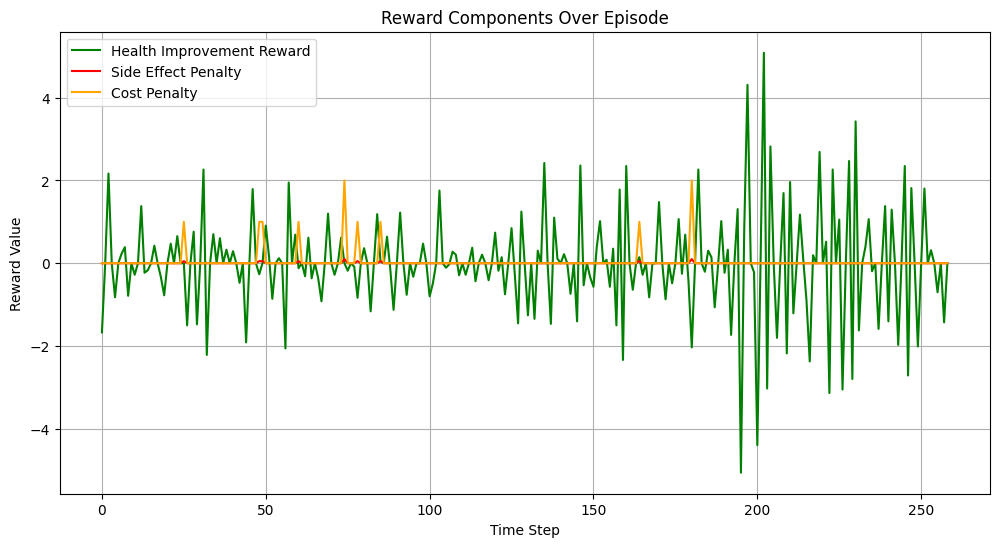

In [ ]:
import matplotlib.pyplot as plt

# Set the figure size for the plot (width=12 inches, height=6 inches)
plt.figure(figsize=(12,6))

# Plot the health improvement reward over time steps in green
plt.plot(reward_health, label='Health Improvement Reward', color='green')

# Plot the side effect penalty over time steps in red
plt.plot(reward_side_effect, label='Side Effect Penalty', color='red')

# Plot the cost penalty over time steps in orange
plt.plot(reward_cost, label='Cost Penalty', color='orange')

# Label x-axis as time step (episode progression)
plt.xlabel('Time Step')

# Label y-axis as reward value (can be positive or negative)
plt.ylabel('Reward Value')

# Set the title of the plot
plt.title('Reward Components Over Episode')

# Show legend to differentiate the plotted lines
plt.legend()

# Enable grid for easier reading of values
plt.grid(True)

# Display the plot
plt.show()

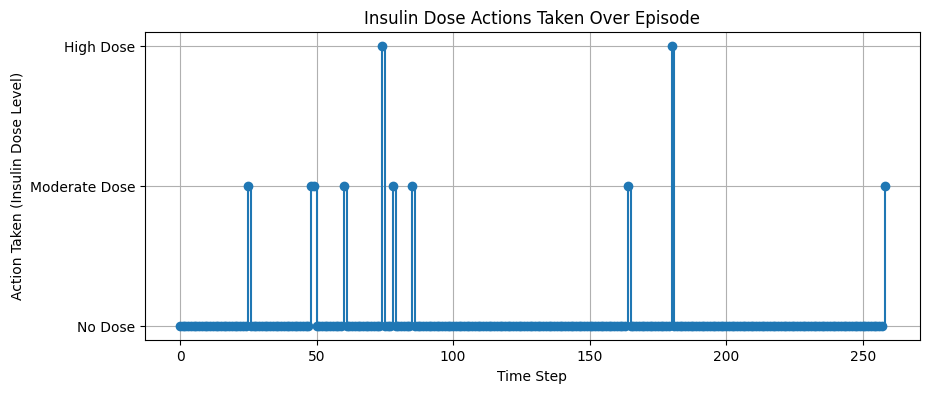

In [ ]:
plt.figure(figsize=(10,4))  # Set figure size (width=10 inches, height=4 inches)

# Plot actions taken over time steps as step-wise plot with markers at each step
plt.plot(actions_taken, drawstyle='steps-post', marker='o')

plt.xlabel('Time Step')  # Label x-axis
plt.ylabel('Action Taken (Insulin Dose Level)')  # Label y-axis

plt.title('Insulin Dose Actions Taken Over Episode')  # Title of the plot

# Set y-axis ticks and labels to represent insulin dose levels clearly
plt.yticks([0,1,2], ['No Dose', 'Moderate Dose', 'High Dose'])

plt.grid(True)  # Enable grid for readability

plt.show()  # Display the plot

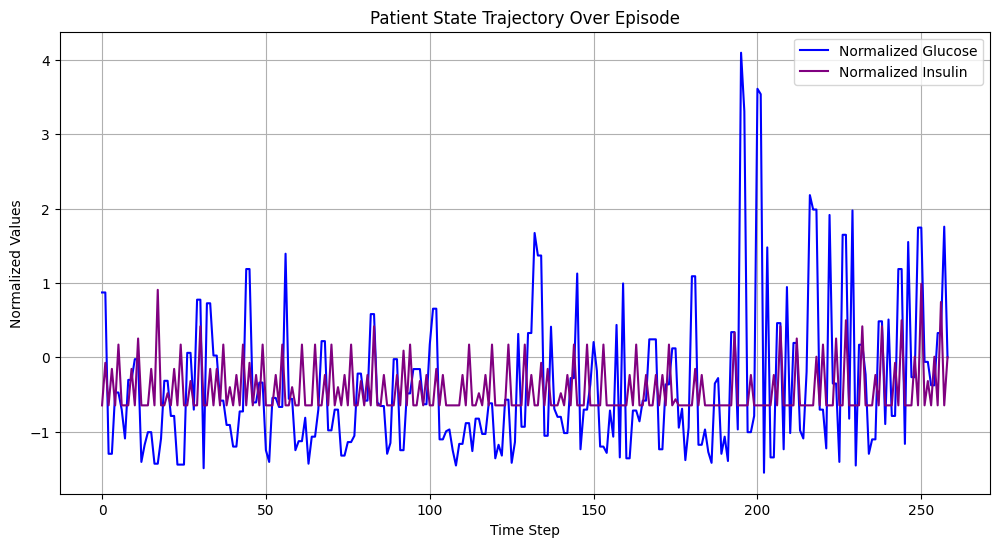

In [ ]:
states = np.array(states)  # Convert list of state arrays to a single NumPy array for easier slicing

plt.figure(figsize=(12,6))  # Set figure size (width=12 inches, height=6 inches)

# Plot normalized glucose values (index 1 in state vector) over time steps in blue
plt.plot(states[:,1], label='Normalized Glucose', color='blue')

# Plot normalized insulin values (index 0 in state vector) over time steps in purple
plt.plot(states[:,0], label='Normalized Insulin', color='purple')

plt.xlabel('Time Step')  # Label x-axis
plt.ylabel('Normalized Values')  # Label y-axis

plt.title('Patient State Trajectory Over Episode')  # Title of the plot

plt.legend()  # Display legend to differentiate lines
plt.grid(True)  # Enable grid for easier reading
plt.show()  # Display the plot

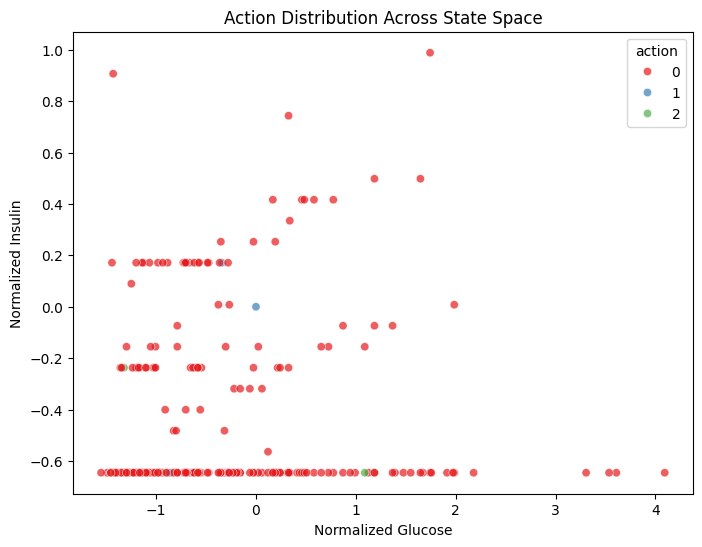

(array([0, 1, 2]), array([249,   8,   2]))
int64


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert states list to NumPy array with shape (timesteps, 2)
states = np.array(states)

# Convert actions_taken list to 1D integer NumPy array
actions_array = np.array(actions_taken).flatten().astype(int)

# Create a DataFrame combining normalized glucose, insulin, and corresponding actions
df_actions = pd.DataFrame({
    'glucose_norm': states[:, 1],  # normalized glucose values
    'insulin_norm': states[:, 0],  # normalized insulin values
    'action': actions_array         # discrete action labels
})

plt.figure(figsize=(8, 6))  # Set figure size

# Create scatterplot of insulin vs glucose, colored by the action taken
sns.scatterplot(
    data=df_actions,
    x='glucose_norm',
    y='insulin_norm',
    hue='action',        # Color points by action category
    palette='Set1',      # Color palette for categorical values
    alpha=0.7            # Set transparency for better visualization
)

plt.title('Action Distribution Across State Space')  # Plot title
plt.xlabel('Normalized Glucose')                      # X-axis label
plt.ylabel('Normalized Insulin')                      # Y-axis label

plt.show()  # Display the plot

# Print unique action values and their counts for analysis
print(np.unique(actions_array, return_counts=True))

# Print the dtype of actions_array to verify it is integer
print(actions_array.dtype)

In [ ]:
# Instantiate the diabetes environment with the prepared dataset
env = DiabetesEnv(pivot_df)

from stable_baselines3 import PPO

# Load the pre-trained PPO model from the saved zip file, passing the environment for compatibility
model = PPO.load("/content/ppo_diabetes_model.zip", env=env)

# Optional: further train (fine-tune) the model on the current environment for 5,000 time steps
model.learn(total_timesteps=5000)

# Save the fine-tuned model to a new file
model.save("/content/ppo_diabetes_model_finetuned")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 211      |
|    ep_rew_mean     | -7.36    |
| time/              |          |
|    fps             | 281      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 248          |
|    ep_rew_mean          | -7.15        |
| time/                   |              |
|    fps                  | 242          |
|    iterations           | 2            |
|    time_elapsed         | 16           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0008154393 |
|    clip_fraction        | 0.0184       |
|    clip_range           | 0.2          |
|    entropy_loss       

In [ ]:
from stable_baselines3 import DQN  # Import Deep Q-Network algorithm

# Instantiate the diabetes environment with the prepared dataset
env = DiabetesEnv(pivot_df)

# Create a DQN model using MLP policy to interact with the environment
dqn_model = DQN('MlpPolicy', env, verbose=1)

# Train the DQN model for 30,000 time steps (adjust as needed)
dqn_model.learn(total_timesteps=30000)

# Save the trained DQN model to disk for later use or evaluation
dqn_model.save("dqn_diabetes_model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 214      |
|    ep_rew_mean      | -193     |
|    exploration_rate | 0.728    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 597      |
|    time_elapsed     | 1        |
|    total_timesteps  | 858      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.533    |
|    n_updates        | 189      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 349      |
|    ep_rew_mean      | -187     |
|    exploration_rate | 0.117    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 414      |
|    time_elapsed     | 6        |
|    total_timesteps  | 2790     |
| train/              |        

In [ ]:
class RuleBasedAgent:
    def __init__(self):
        pass  # No initialization needed for this simple agent

    def act(self, state):
        glucose = state[1]  # Extract normalized glucose value from state

        # Simple heuristic policy:
        if glucose < -0.5:
            return 0  # No insulin dose if glucose is low
        elif glucose < 0.5:
            return 1  # Moderate dose if glucose is moderately high
        else:
            return 2  # High dose if glucose is high

# Example evaluation loop using the rule-based agent
agent = RuleBasedAgent()
obs, _ = env.reset()  # Reset environment to start
done = False
rewards = []

while not done:
    action = agent.act(obs)  # Get action based on current observation/state
    obs, reward, done, _, _ = env.step(action)  # Take action in environment
    rewards.append(reward)  # Record received reward

# Print total reward accumulated over episode
print(f"Rule-Based Total Reward: {sum(rewards)}")

Rule-Based Total Reward: -35.41315799951553


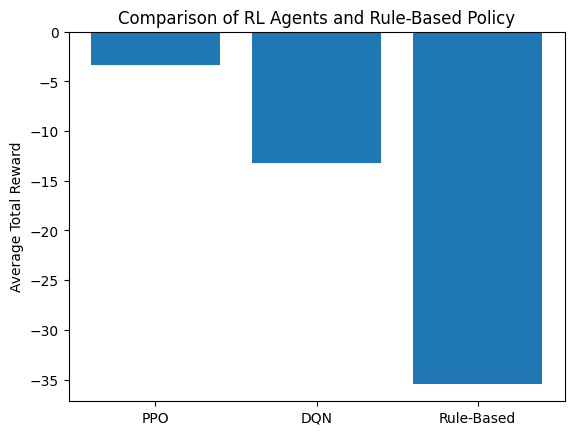

In [ ]:
def evaluate_model(model, env, episodes=5):
    all_rewards = []  # Store total rewards per episode
    for ep in range(episodes):
        obs, _ = env.reset()  # Reset environment at the start of each episode
        done = False
        ep_rewards = []  # Rewards collected during the current episode
        while not done:
            # Predict action using the RL model's policy based on current observation
            action, _ = model.predict(obs)
            # Take action in environment, receive next state and reward
            obs, reward, done, _, _ = env.step(action)
            ep_rewards.append(reward)  # Record reward for this step
        all_rewards.append(sum(ep_rewards))  # Sum rewards at episode end
    return all_rewards  # Return list of total rewards per episode

# Evaluate PPO model over 5 episodes
ppo_rewards = evaluate_model(model, env)

# Evaluate DQN model over 5 episodes
dqn_rewards = evaluate_model(dqn_model, env)

# Rule-based evaluation results were collected previously in `rewards`

import matplotlib.pyplot as plt

# Plot average total rewards of each agent type for comparison
plt.bar(
    ['PPO', 'DQN', 'Rule-Based'],                      # Agent labels
    [np.mean(ppo_rewards), np.mean(dqn_rewards), sum(rewards)]  # Average rewards per agent
)
plt.ylabel('Average Total Reward')  # Y-axis label
plt.title('Comparison of RL Agents and Rule-Based Policy')  # Plot title
plt.show()  # Display bar chart

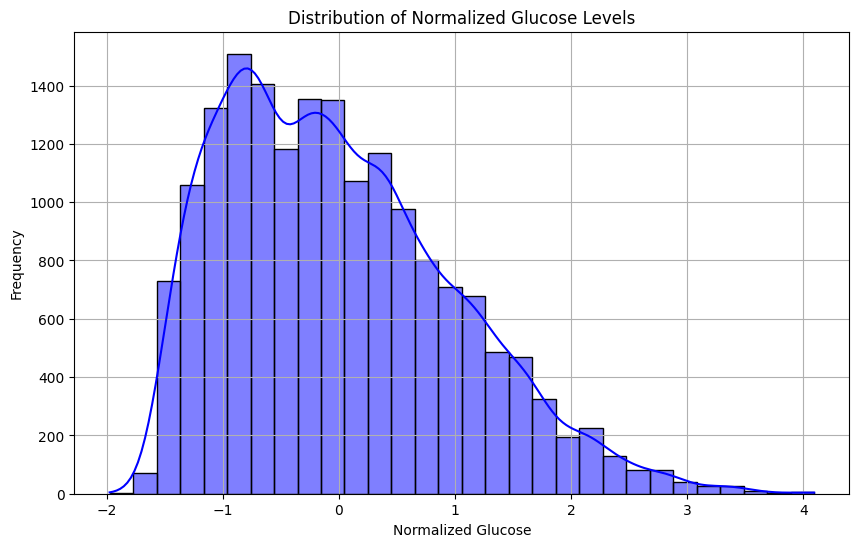

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))  # Set figure size (width=10 inches, height=6 inches)

# Plot histogram with KDE (kernel density estimate) of normalized glucose values
sns.histplot(
    pivot_df['glucose_norm'],  # Data to plot
    bins=30,                   # Number of histogram bins
    kde=True,                  # Overlay KDE curve
    color='blue'               # Bar color
)

plt.title('Distribution of Normalized Glucose Levels')  # Title of the plot
plt.xlabel('Normalized Glucose')                        # X-axis label
plt.ylabel('Frequency')                                 # Y-axis label

plt.grid(True)  # Enable grid for better readability

plt.show()  # Display the plot

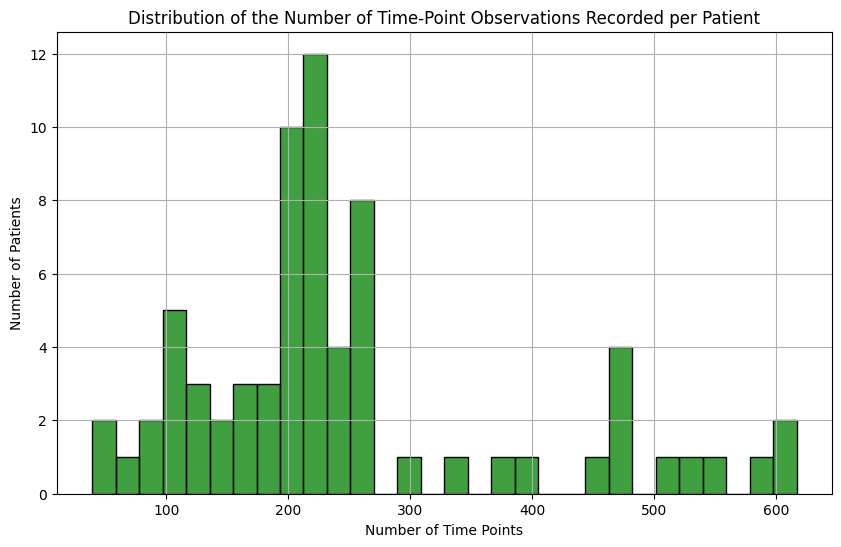

In [ ]:
# Count the number of observations (rows) per patient_id
obs_counts = pivot_df.groupby('patient_id').size()

plt.figure(figsize=(10,6))  # Set figure size (width=10 inches, height=6 inches)

# Plot histogram of the number of observations per patient
sns.histplot(
    obs_counts,  # Data: counts of time points per patient
    bins=30,     # Number of bins for the histogram
    kde=False,   # Do not show KDE curve
    color='green'  # Color of the bars
)

plt.title('Distribution of the Number of Time-Point Observations Recorded per Patient')  # Plot title
plt.xlabel('Number of Time Points')  # X-axis label
plt.ylabel('Number of Patients')     # Y-axis label

plt.grid(True)  # Enable grid lines for better readability

plt.show()  # Show the plot